In [16]:
import os
from matplotlib import pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')


In [20]:

DATA_DIR_TRAIN = "C:/Users/igofo/Documents/HuaweiCertificacion/MNIST/train" # Training set information
DATA_DIR_TEST = "C:/Users/igofo/Documents/HuaweiCertificacion/MNIST/test" # Test set information
# Read data.
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST ) 
# Display the dataset features.
print('Data volume of the training dataset:',ds_train.get_dataset_size())
print('Data volume of the test dataset:',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('Image length/width/channels:',image['image'].shape)
print('Image label style:',image['label'])    # Total 10 label classes which are represented by numbers from 0 to 9.


Data volume of the training dataset: 60000
Data volume of the test dataset: 10000
Image length/width/channels: (28, 28, 1)
Image label style: 1


In [21]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    # Define the resizing, normalization, and channel conversion of the map operation.
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale,shift)
    hwc2chw_op = CV.HWC2CHW()
    # Perform the map operation on the dataset.
    ds = ds.map(input_columns="image", operations=[rescale_op,resize_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    # Set the shuffle parameter and batch size.
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds


[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:12:39.676.139 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:12:39.676.139 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:12:39.691.770 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:12:39.691.770 [mindspore\dataset\core\validator_helpers.py:744] 'TypeCas

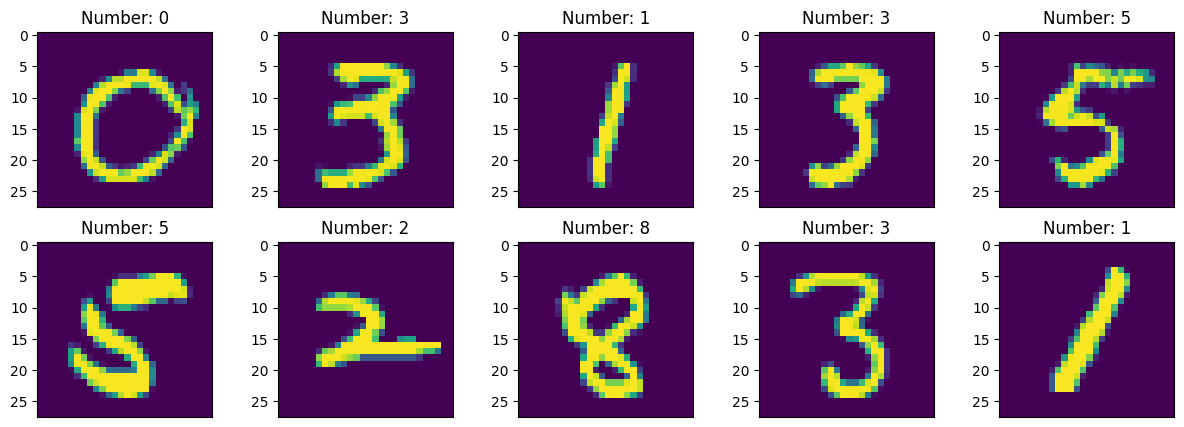

In [22]:
# Display the first 10 images and the labels, and check whether the images are correctly labeled.
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

In [23]:
# Create a model. The model consists of three fully connected layers. The final output layer uses softmax for classification (10 classes consisting of numbers 0 to 9.)
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(784, 512, activation='relu')  
        self.fc2 = nn.Dense(512, 128, activation='relu')
        self.fc3 = nn.Dense(128, 10, activation=None)
           
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output) 
        output = self.fc3(output)
        return output  


In [24]:
# Create a network, loss function, validation metric, and optimizer, and set related hyperparameters.
lr = 0.001
num_epoch = 10
momentum = 0.9

net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr) 


In [25]:
# Build a model.
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck)
# Generate a dataset.
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)
# Train the model.
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print("============== Starting Training ==============")
model.train(num_epoch, ds_train,callbacks=[ckpoint_cb,loss_cb,time_cb ],dataset_sink_mode=False)


[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:17:15.350.919 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:17:15.359.926 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:17:15.360.510 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(24020:4196,MainProcess):2024-02-12-17:17:15.360.510 [mindspore\dataset\core\validator_helpers.py:744] 'TypeCas

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.09952111542224884
Train epoch time: 21922.409 ms, per step time: 11.692 ms
epoch: 2 step: 1875, loss is 0.06391245126724243
Train epoch time: 31307.327 ms, per step time: 16.697 ms
epoch: 3 step: 1875, loss is 0.1002153605222702
Train epoch time: 32194.855 ms, per step time: 17.171 ms
epoch: 4 step: 1875, loss is 0.022492919117212296
Train epoch time: 34026.990 ms, per step time: 18.148 ms
epoch: 5 step: 1875, loss is 0.004705979488790035
Train epoch time: 36836.674 ms, per step time: 19.646 ms
epoch: 6 step: 1875, loss is 0.0007411565165966749
Train epoch time: 37538.119 ms, per step time: 20.020 ms
epoch: 7 step: 1875, loss is 0.0012529087252914906
Train epoch time: 37991.839 ms, per step time: 20.262 ms
epoch: 8 step: 1875, loss is 0.024556247517466545
Train epoch time: 38597.412 ms, per step time: 20.585 ms
epoch: 9 step: 1875, loss is 0.07746293395757675
Train epoch time: 40381.015 ms, per step time: 21

In [26]:
# Use the test set to validate the model and print the overall accuracy.
metrics=model.eval(ds_eval)
print(metrics)


{'Accuracy': 0.9800681089743589}
